# Sales ratio study with real data

AssessPy can easily be used with various data to conduct a sales ratio study. In this vignette, we demonstrate this process using real data from the Cook County Assessor's Office (CCAO). The CCAO publishes assessments and sales on the [Cook County Open Data Portal](https://datacatalog.cookcountyil.gov/stories/s/i22y-9sd2).

## Basics of sales ratio studies

A sales ratio is the ratio of the assessor's estimate of a property's value to the sale price of a property. A sales ratio study is a report on how accurately and fairly an assessor predicted property values. The CCAO has a [rigorous set of rules](https://github.com/ccao-data/wiki/blob/master/SOPs/Open-Data.md) that govern how sales ratios studies are conducted.

In general, there are four important statistics produced in sales ratio studies, listed in the table below. It is important to understand that these statistics are calculated based on properties that sell. In most jurisdictions, the number of properties that sell in any single year is a very small percentage of the overall number of properties. In order to characterize the quality of the assessment role in a jurisdiction, we draw an inference from this small number of properties.

| Statistic               | Acceptable Range | Interpretation                                                                                                                                                                             |
|------------------------|------------------------|------------------------|
| COD                     | 5 - 15           | How often properties with the *same* sale price receive the same predicted market value. Lower CODs indicate more fairness between similarly priced properties.                            |
| PRD                     | .98 - 1.03       | How often properties with *different* sale prices receive the proportionately different predicted market values. Lower PRDs indicate more fairness between low and high-priced properties. |
| PRB                     | -.05 - .05       | PRB is a different approach to measuring fairness across homes with different sale prices.                                                                                                 |
| Median Assessment Ratio | .095 - 1.05      | The median ratio measures whether the most common ratios accurately reflect sale prices                                                                                                    |
| Sales Chasing (E.4)     | $\le$ 5%         | Measures the degree to which the statistics above are *true* reflections of the quality of assessments.                                                                                    |

### Interpretation of sales ratio statistics

Suppose you have a jurisdiction with a median ratio of one and a COD of 20. This indicates that, on average, the assessor predicts the sale price of properties accurately, but with a high dispersion. To use the dart board analogy, the assessor's darts fall in a wide area centered around the bullseye. On the other hand, if the median ratio is greater than one, and the COD is lower than 10, this indicates that the assessor consistently over-estimates the value of properties in their jurisdiction.

Suppose you have a jurisdiction with a low COD and high PRD & PRB. This indicates that the assessor consistently under-estimates higher value properties, and over-estimates lower value properties. Properties of similar value receive similar estimates, but there is structural inequality in the overall system.

Finally, suppose you have a jurisdiction with CODs, PRDs, and PRBs all within the acceptable range, but there is strong evidence of selective appraisals. In this case, the sales value statistics should be disregarded, since they are based on a non-random selection of the underlying set of properties. They cannot be used to characterize the quality of the assessment role.

## Loading data into Python

There are many ways to load data into Python. Below are some example methods:

### jsonlite

Socrata can also return raw JSON if you manually construct a query URL. Follow the [API docs](https://dev.socrata.com/foundry/datacatalog.cookcountyil.gov/uzyt-m557) to alter your query. The raw JSON output can be read using the `read_json` from `pandas`.

In [43]:
%%capture
import json
import pandas as pd

# Load 100k rows of 2020 residential (major class 2) assessment data
assessments = pd.read_json(
  "https://datacatalog.cookcountyil.gov/resource/uzyt-m557.json?$where=starts_with(class,'2')&year=2020&$limit=100000"
  )

# Load 100k rows of 2020 sales data
sales = pd.read_json(
  "https://datacatalog.cookcountyil.gov/resource/wvhk-k5uv.json?year=2020&$limit=100000"
  )

# read_json removes leading zeroes, add them back
assessments.pin = assessments.pin.astype(str).str.zfill(14)
sales.pin = sales.pin.astype(str).str.zfill(14)

### From a CSV or Excel

Python can also read Excel and CSV files stored on your computer.

```python
# CSV files
assessments = pd.read_csv("C:/Users/MEEE/Documents/.... where is your file ?")
sales = pd.read_csv("C:/Users/MEEE/Documents/.... where is your file ?")

# Excel files
assessments = pd.read_excel("C:/Users/MEEE/Documents/.... where is your file ?", sheet_name = "your sheet")
sales = pd.read_excel("C:/Users/MEEE/Documents/.... where is your file ?", sheet_name = "your sheet")
```

### Connecting to a relational database

The CCAO's Data Science team uses Amazon Athena. Python can connect to a wide range of database engines.

```python

from pyathena import connect

# Connect to the database
aws_athena_conn = connect(
  s3_staging_dir="your-staging-directory",
  region_name="your-aws-region"
  )

# Fetch data from the SQL server
assessments = pd.read_sql_query("SELECT * FROM your-database.your-table", aws_athena_conn)
```


## Sales ratio study

In this section, we will use data published on the [Cook County Open Data Portal](https://datacatalog.cookcountyil.gov/Property-Taxation/Cook-County-Assessor-s-Residential-Assessments/uzyt-m557) to produce an example sales ratio study.

### Prepare the data

Above, we pulled assessment and sales data from the Open Data Portal. In order to produce our sales ratio statistics, our data needs to be formatted in 'long form,' meaning that each row is a property in a given year. The county provides *assessed value* on the Open Data Portal. For residential properties, we need to multiply assessed value by 10 to get fair market value. [Assessment levels](https://prodassets.cookcountyassessor.com/s3fs-public/form_documents/classcode.pdf) can differ for other classes.

In [44]:
# Pivot to longer, Join the two datasets based on PIN, keeping only those that have assessed
# values AND sales
combined = pd.merge(
  pd.melt(
    assessments,
    id_vars=["pin", "year", "township_name"],
    value_vars=["mailed_tot", "certified_tot", "board_tot"],
    var_name = "stage",
    value_name='assessed'
    ),
    sales[["pin", "year", "sale_price", "is_multisale"]],
    on = ["pin", "year"],
    how = "inner"
)

# Remove multisales, then calculate the ratio for each property
# and assessment stage
combined = combined[combined.is_multisale == False]
combined['ratio'] = combined.assessed * 10 / combined.sale_price

### Sales ratio statistics by township

Cook County has jurisdictions called townships that are important units for assessment. In the chunk below, we calculate sales ratio statistics by township.

In [45]:
import numpy as np
import assesspy as ap
import warnings
warnings.filterwarnings('ignore')

# For each town and stage, calculate COD, PRD, and PRB, and their respective
# confidence intervals then arrange by town name and stage of assessment
town_stats = combined[combined.assessed > 0].copy(deep=True)
town_stats['stage'] = town_stats.stage.astype('category').cat.reorder_categories(['mailed_tot', 'certified_tot', 'board_tot'])
town_stats = town_stats.groupby(["township_name", "stage"]).apply(
        lambda x: pd.Series({
            'n':np.size(x['pin']),
            'cod':np.round(ap.cod(ratio = x['ratio']), 2),
            'cod_ci':np.round(ap.cod_ci(ratio = x['ratio']), 2),
            'prd':np.round(ap.prd(x['assessed'], x['sale_price']), 2),
            'prd_ci':np.round(ap.prd_ci(x['assessed'], x['sale_price']), 2),
            'prb':ap.prb(x['assessed'], x['sale_price'], 3)
            })
        )

town_stats['prb_ci'] = town_stats.prb.str['95% ci']
town_stats['prb'] = town_stats.prb.str['prb']
town_stats['cod_met'] = town_stats.cod.apply(ap.cod_met)
town_stats['prd_met'] = town_stats.prd.apply(ap.prd_met)
town_stats['prb_met'] = town_stats.prb.apply(ap.prb_met)
town_stats = town_stats[['n', 'cod', 'cod_ci', 'cod_met', 'prd', 'prd_ci', 'prd_met', 'prb', 'prb_ci', 'prb_met']]
town_stats = town_stats[town_stats['n'] >= 70]

town_stats

n    cod          cod_ci  cod_met   prd  \
township_name stage                                                       
Barrington    mailed_tot      349  21.99  [19.29, 24.31]    False  1.04   
              certified_tot   349  22.06  [20.05, 24.43]    False  1.04   
              board_tot       349  20.76  [18.81, 22.88]    False  1.05   
New Trier     mailed_tot      124  25.53  [20.96, 30.63]    False  1.08   
              certified_tot   124  25.73  [20.71, 31.65]    False  1.08   
              board_tot       124  24.08  [19.07, 29.56]    False  1.08   
Northfield    mailed_tot      385  17.65  [16.02, 19.38]    False  1.05   
              certified_tot   385  17.75  [16.05, 19.68]    False  1.05   
              board_tot       385  16.99  [15.35, 18.57]    False  1.05   
Palatine      mailed_tot     2127  15.30   [14.3, 16.79]    False  1.01   
              certified_tot  2127  15.23  [14.35, 16.05]    False  1.01   
              board_tot      2127  15.00   [14.1, 16.08]     True  1.01   
Wheeling      mailed_tot     2034  16.78   [16.06, 17.5]    False  1.02   
              certified_tot  2034  16.66   [15.9, 17.41]    False  1.02   
              board_tot      2034  16.41  [15.69, 17.17]    False  1.02   

                                   prd_ci  prd_met    prb           prb_ci  \
township_name stage                                                          
Barrington    mailed_tot     [1.02, 1.07]    False  0.002   [0.001, 0.004]   
              certified_tot  [1.02, 1.07]    False  0.002   [0.001, 0.004]   
              board_tot      [1.03, 1.07]    False  0.001    [-0.0, 0.003]   
New Trier     mailed_tot     [1.04, 1.13]    False  0.005   [0.001, 0.008]   
              certified_tot  [1.04, 1.14]    False  0.004     [0.0, 0.008]   
              board_tot      [1.04, 1.15]    False  0.003  [-0.001, 0.007]   
Northfield    mailed_tot     [1.03, 1.07]    False  0.001     [0.0, 0.003]   
              certified_tot  [1.03, 1.07]    False  0.001     [0.0, 0.003]   
              board_tot      [1.03, 1.07]    False  0.001    [-0.0, 0.002]   
Palatine      mailed_tot      [1.0, 1.01]     True  0.002   [0.001, 0.003]   
              certified_tot   [1.0, 1.01]     True  0.002   [0.001, 0.003]   
              board_tot       [1.0, 1.01]     True  0.002   [0.001, 0.002]   
Wheeling      mailed_tot     [1.01, 1.02]     True  0.001   [0.001, 0.002]   
              certified_tot  [1.01, 1.02]     True  0.001   [0.001, 0.002]   
              board_tot      [1.01, 1.02]     True  0.001     [0.0, 0.002]   

                             prb_met  
township_name stage                   
Barrington    mailed_tot        True  
              certified_tot     True  
              board_tot         True  
New Trier     mailed_tot        True  
              certified_tot     True  
              board_tot         True  
Northfield    mailed_tot        True  
              certified_tot     True  
              board_tot         True  
Palatine      mailed_tot        True  
              certified_tot     True  
              board_tot         True  
Wheeling      mailed_tot        True  
              certified_tot     True  
              board_tot         True

### Median ratios by sale price

Suppose you are concerned that an assessment role is unfair to lower value homes. One way to visually see whether ratios are systematically biased with respect to property value is to plot median ratios by decile. In our sample data, we can see each decile of sale price using the `quantile` function:

In [46]:
deciles = np.linspace(.1, .9, 9).round(1)

median_ratios = pd.DataFrame(deciles, columns = ['Decile'])
median_ratios['Decile'] = (median_ratios.Decile * 100).astype(int).astype(str) + '%'
median_ratios['Sale Price'] = np.quantile(combined.sale_price, deciles)
median_ratios['Sale Price'] = median_ratios['Sale Price'].apply(lambda x: "${:,.0f}".format(x))

median_ratios

,Decile,Sale Price
0,10%,"$132,000"
1,20%,"$175,000"
2,30%,"$216,000"
3,40%,"$255,000"
4,50%,"$295,000"
5,60%,"$332,000"
6,70%,"$381,000"
7,80%,"$465,000"
8,90%,"$605,000"


Using these decile values, we can graph sales ratios across each decile of value. Here, we use the very useful `matplotlib` package to make an attractive graph.

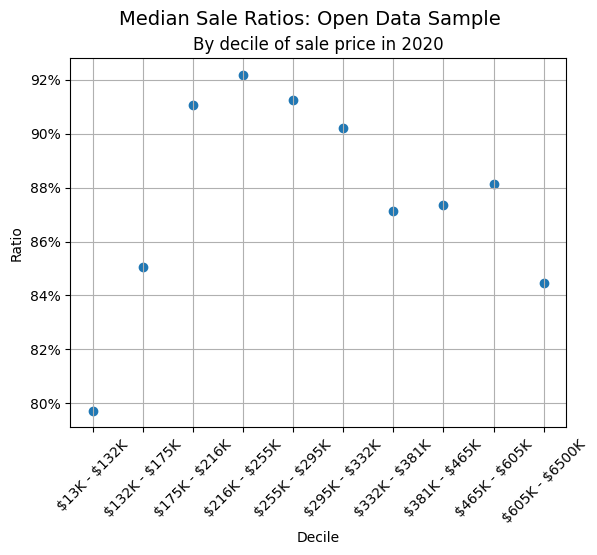

In [47]:
import matplotlib.pyplot as plt
plt.style.use('default')
warnings.filterwarnings('ignore')

graph_data = combined
graph_data['rank'] = pd.qcut(graph_data['sale_price'], 10, labels=False)
graph_data['rank'] = graph_data['rank'] + 1
graph_data['decile'] = pd.qcut(graph_data['sale_price'] / 1000, 10, precision=0)
graph_data['decile'] = graph_data['decile'].astype(str).str.replace('(', '\$')
graph_data['decile'] = graph_data['decile'].str.replace(', ', ' - \$')
graph_data['decile'] = graph_data['decile'].str.replace('.0', 'K', regex=False)
graph_data['decile'] = graph_data['decile'].str.replace(']', '')
graph_data['decile'] = graph_data['decile'].str.replace(' - \$9050K', '+', regex=False)
graph_data = graph_data.groupby(['rank', 'decile']).apply(
        lambda x: pd.Series({
            'Median Sales Ratio':np.median(x['ratio']),
            })
        )

graph_data = graph_data.reset_index()
plt.scatter(graph_data['decile'], graph_data['Median Sales Ratio'])
plt.xticks(rotation=45)
plt.xlabel('Decile')
plt.ylabel('Ratio')
plt.suptitle("Median Sale Ratios: Open Data Sample", fontsize=14)
plt.title("By decile of sale price in 2020")
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.grid()
plt.show()

### Detecting selective appraisals

Selective appraisal, sometimes referred to as sales chasing, happens when a property is reappraised to shift its assessed value toward its actual sale price. The CCAO requires selective appraisal detection in every sales ratio study. This is because selective appraisal renders all other sales ratio statistics suspect. In the code below, we construct two sets of ratios, one normally distributed, and one 'chased.'

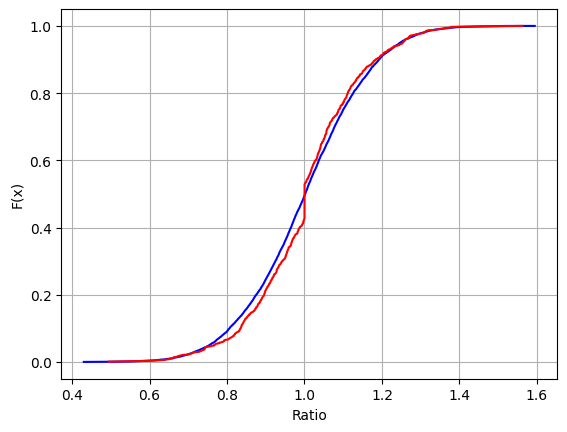

{'Blue Chased?': False, 'Red Chased?': True}

In [48]:
from statsmodels.distributions.empirical_distribution import ECDF

# Generate fake data with normal vs chased ratios
normal_ratios = np.random.normal(1, 0.15, 10000)
chased_ratios = list(np.random.normal(1, 0.15, 900)) + [1] * 100

# Plot to view discontinuity
ecdf_normal = ECDF(normal_ratios)
ecdf_chased = ECDF(chased_ratios)
plt.plot(ecdf_normal.x, ecdf_normal.y, color = 'blue')
plt.plot(ecdf_chased.x, ecdf_chased.y, color = 'red')
plt.xlabel('Ratio')
plt.ylabel('F(x)')
plt.grid()
plt.show()

{'Blue Chased?': ap.detect_chasing(normal_ratios), 'Red Chased?': ap.detect_chasing(chased_ratios)}

Ratios that include selective appraisals will be clustered around the value of one much more than ratios produced from a CAMA system. We can see this visually in the graph where the cumulative distribution curve shows a discontinuous jump, or 'flat spot', near one.

## GINI Coefficient for Vertical Equity
Another way to test the vertical equity of assessments is by looking at the differences in the GINI coefficient, a widely used metric to analyze inequality. The first step in this process is to order the data by sale price. Once done, the GINI coefficient is calculated for both sale and assessed value (both ordered by sale price). A graph of the Lorenz Curve is presented below.

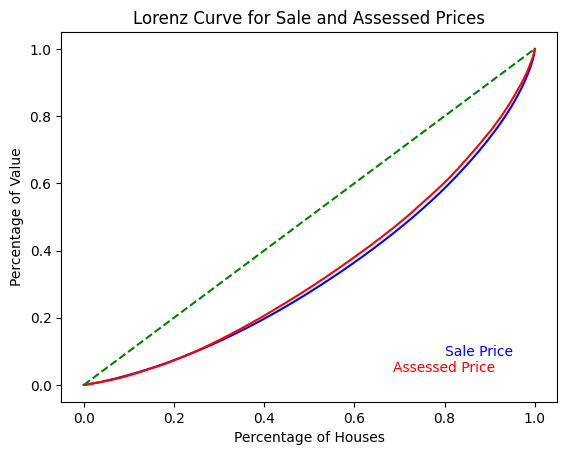

In [49]:
GINI_data = combined[['sale_price', 'assessed']].sort_values(by='sale_price')

sale_price = GINI_data['sale_price']
assessed = GINI_data['assessed']

lorenz_data_price = pd.DataFrame({
    'Percentage': np.concatenate(([0], np.cumsum(sale_price) / np.sum(sale_price))),
    'CumulativePercentage': np.concatenate(([0], np.arange(1, len(sale_price) + 1) / len(sale_price)))
})

lorenz_data_assessed = pd.DataFrame({
    'Percentage': np.concatenate(([0], np.cumsum(assessed) / np.sum(assessed))),
    'CumulativePercentage': np.concatenate(([0], np.arange(1, len(assessed) + 1) / len(assessed)))
})

fig, ax = plt.subplots()

ax.plot(lorenz_data_price['CumulativePercentage'], lorenz_data_price['Percentage'], color='blue')
ax.plot(lorenz_data_assessed['CumulativePercentage'], lorenz_data_assessed['Percentage'], color='red')
ax.plot([0, 1], [0, 1], linestyle='dashed', color='green')

ax.text(0.8, 0.1, 'Sale Price', color='blue', va='center')
ax.text(0.8, 0.05, 'Assessed Price', color='red', ha='center', va='center')

ax.set_title('Lorenz Curve for Sale and Assessed Prices')
ax.set_xlabel('Percentage of Houses')
ax.set_ylabel('Percentage of Value')

plt.show()


In this graphic, the green line (Line of Equality) represents a hypothetical environment, where housing valuations are completely equitable. The two other curves represent the percentage of value (y axis), encompassed by an increasing percentage of housing (x-axis). Since housing is ordered by sale prices, the rate of increase is increasing. 

What this chart shows is that for the vast majority of the income distribution, assessed values are closer to the Line of Equity. This can be interpreted two ways. 

1st, when the assessed line is above the sale price, the gap between the the two lines at any individual point, represents the cumulative over-assessment for all houses at that value or below.

2nd, it means that the GINI coefficient for sale price is going to be higher than the GINI coefficient for assessed price (a larger area between the the curve and the Line of Equality). 

In this situation, the graph represents a regressive housing policy. This is not immediately intuitive, but to conceptualize this, think of an exaggerated "progressive" policy, where all houses were valued at $0 with one house encompassing all the assessed value. In this distribution, curve would be at 0 until the final house, where it would jump to 100% of the cumulative value (a GINI of 1). Thus, a higher GINI represents a more progressive assessment policy, where tax assessments are larger as housing value increases. 

To translate these curves to a metric, the Kakwani and Modified Kakwani Index are used. These are straightforward, with the following definitions:

Kakwani Index: Assessed GINI - Price GINI

Modified Kakwani Index: Assessed GINI / Price GINI

In [51]:

from assesspy.utils import check_inputs


# Check inputs
check_inputs(assessed, sale_price)

dataset = list(zip(sale_price, assessed))
dataset.sort(key=lambda x: x[0])
assessed_price = [a for _, a in dataset]
sale_price = [s for s, _ in dataset]
n = len(assessed_price)

G_assessed = sum(a * (i + 1) for i, a in enumerate(assessed_price))
G_assessed = 2 * G_assessed / sum(assessed_price) - (n + 1)
GINI_assessed = G_assessed / n

G_sale = sum(s * (i + 1) for i, s in enumerate(sale_price))
G_sale = 2 * G_sale / sum(sale_price) - (n + 1)
GINI_sale = G_sale / n

MKI = GINI_assessed / GINI_sale
KI = GINI_assessed - GINI_sale

print(MKI)
print(KI)

0.9413450479995565
-0.019737136571213898



The output for the Modified Kakwani Index is .9413, and the Kakwani Index is -.0197. According to the following table, this means that the assessment policy is regressive. 

| Range              | Interpretation     |
|--------------------|--------------------|
| Kakwani Index      |                    |
| < 0                | Regressive Policy  |
| = 0                | Vertical Equity    |
| > 0                | Progressive Policy |
| Modified Kakwani Index |                  |
| < 1                | Regressive Policy  |
| = 1                | Vertical Equity    |
| > 1                | Progressive Policy |
